In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from operator import itemgetter
%matplotlib inline

sns.set()
import matplotlib.style as style
style.available
style.use('fivethirtyeight')

In [2]:
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('max_columns', 60)

In [3]:
#one hot encode cat variables
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue # removes no cat cols
    return df

    return df

def fill_missing_values(df):
    df['bathrooms'] = df['bathrooms'].fillna(0)
    df['bedrooms'] = df['bedrooms'].fillna(0)
    df['beds'] = df['beds'].fillna(0)
    df['host_response_rate'] = df['host_response_rate'].fillna(0)

    review_cols = df.filter(like='review_scores').columns
    for col in review_cols:
        df[col] = df[col].fillna(df[col].mean())
    
    return df

def drop_columns(df):
    cols_to_drop = ['listing_url', 'requires_license','jurisdiction_names','host_acceptance_rate', 
                    'scrape_id', 'last_scraped', 'experiences_offered','transit',
                    'name', 'summary', 'space', 'description', 
                    'neighborhood_overview', 'notes', 'thumbnail_url', 
                    'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
                    'host_url', 'host_name', 'host_since', 'host_location', 
                    'host_about', 'host_thumbnail_url','calendar_updated',
                    'host_picture_url', 'host_neighbourhood','host_total_listings_count',
                    'host_has_profile_pic', 'street','neighbourhood', 'state', 'latitude','longitude',
                    'require_guest_profile_picture', 'require_guest_phone_verification',
                    'calculated_host_listings_count','license','square_feet','host_listings_count',
                    'host_verifications','host_identity_verified','zipcode','market','smart_location',
                    'country_code','country','is_location_exact','amenities','weekly_price','monthly_price',
                    'maximum_nights','calendar_last_scraped','first_review','last_review','city',
                    'availability_30','availability_60','availability_90','availability_365',
                    'instant_bookable','reviews_per_month','security_deposit']
    df = df.drop(axis=1,columns=cols_to_drop)
    return df

def clean_reviews(reviews_df):
    reviews_df["date"] = pd.to_datetime(reviews_df["date"],format="%Y-%m-%d",errors="coerce")
    reviews_df['year'] = pd.DatetimeIndex(reviews_df['date']).year
    reviews_df['month'] = pd.DatetimeIndex(reviews_df['date']).month
    reviews_df.drop(axis=1,columns=['comments','reviewer_id','reviewer_name'],inplace=True)
    return reviews_df

# Clean up calender remove all entries without a price
def clean_calendar(cal_df):
    # Drop any rows that do not have a price. These are the rows that are unavailable
    cal_df.dropna(axis=0,how='any',subset=['price'])
    cal_df.drop(axis=1,columns=['available'],inplace=True)
    
    cal_df = cal_df.dropna(axis=0,how='all')
    
    #Rename price field so there are not 2 after join
    cal_df = cal_df.rename(columns={"price":"reserve_price"})

    #Convert price to a float
    cal_df["reserve_price"] = cal_df["reserve_price"].str.replace('$','')
    cal_df["reserve_price"] = pd.to_numeric(cal_df["reserve_price"],errors="coerce")
    
    #Convert date to a timestamp and extract year and month
    cal_df["date"] = pd.to_datetime(cal_df["date"],format="%Y-%m-%d",errors="coerce")
    cal_df['year'] = pd.DatetimeIndex(cal_df['date']).year
    cal_df['month'] = pd.DatetimeIndex(cal_df['date']).month
    cal_df['dayofweek'] = pd.DatetimeIndex(cal_df['date']).dayofweek
    return cal_df

# Clean up listings, fix price, convert date and drop unused columns
def clean_listings(listings_df):
    #prepare for merge by renaming columns
    listings_df = listings_df.rename(columns={"id":"listing_id"})

    #convert price to a float
    listings_df["price"] = listings_df["price"].str.replace('$','')
    listings_df["price"] = pd.to_numeric(listings_df["price"],errors="coerce")
    
    listings_df["cleaning_fee"] = listings_df["cleaning_fee"].str.replace('$','')
    listings_df['cleaning_fee'] = listings_df['cleaning_fee'].fillna("0")
    listings_df['cleaning_fee'] = pd.to_numeric(listings_df['cleaning_fee'],errors="coerce")

    listings_df = drop_columns(listings_df)
    listings_df = fill_missing_values(listings_df)
    listings_df = listings_df.dropna(axis=0,how='all')
    
    #Convert Response Rate to a number
    listings_df['host_response_rate'] = listings_df['host_response_rate'].astype(str)
    listings_df['host_response_rate'] = listings_df['host_response_rate'].str.replace("%", "").astype("float")
    return listings_df
    
# Remove columns that are completely empty and
def join_frames(listings_df, cal_df):
    #remove columns that are completely null
    merged_df = pd.merge(listings_df, cal_df, on = 'listing_id')
    
    #drop merged rows w/ a reserved price - probably use inner join
    merged_df = merged_df.dropna(axis=0,how='any',subset=['reserve_price'])
    
    return merged_df


def clean_up_feature_name(feature_name):
    clean_name = feature_name.replace('neighbourhood_group_cleansed_','')
    clean_name = clean_name.replace('room_type_','')
    return clean_name

In [4]:
# Load the data
listings_df = pd.read_csv('./seattle/listings.csv') 
cal_df = pd.read_csv('./seattle/calendar.csv')

print("Listings Size: " + str(listings_df.shape[0]))
print("Cal Size: " + str(cal_df.shape[0]))

listings_df = clean_listings(listings_df)
cal_df = clean_calendar(cal_df)

reviews_df = pd.read_csv('./seattle/reviews.csv') 
reviews_df = clean_reviews(reviews_df)
print("Reviews Size: " + str(reviews_df.shape[0]))

availability_df = join_frames(listings_df,cal_df)

Listings Size: 3818
Cal Size: 1393570
Reviews Size: 84849


In [5]:
print("Min Review Date: " + str(reviews_df.date.min()))
print("Max Review Date: " + str(reviews_df.date.max()))

Min Review Date: 2009-06-07 00:00:00
Max Review Date: 2016-01-03 00:00:00


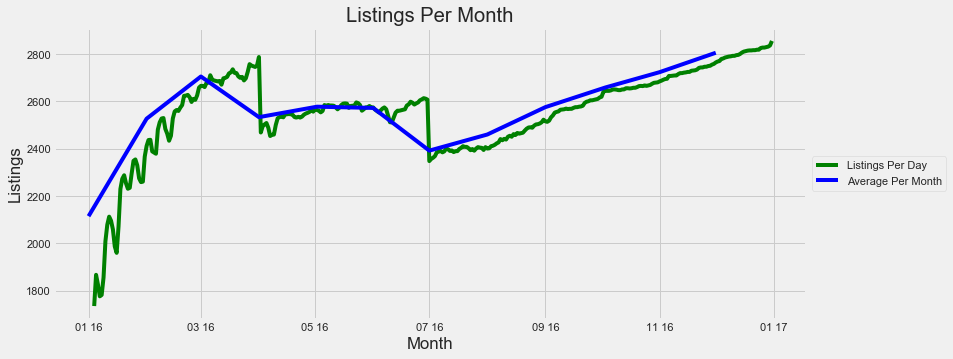

Average Listings Per Month: listing_count    2556.889807
dtype: float64


In [6]:
cal_listings_per_day = availability_df[(availability_df['year'] == 2016)].groupby('date').agg(
    listing_count = ('listing_id',lambda x: x.count())
)

cal_listings_per_month = cal_listings_per_day.copy()
cal_listings_per_month = cal_listings_per_month.resample('BMS').mean()

fig, ax = plt.subplots(figsize=(12, 5))

locator = mdates.AutoDateLocator()

ax.plot(cal_listings_per_day.index.values,
        cal_listings_per_day.listing_count,
        label='Listings Per Day',
        color='green')

ax.plot(cal_listings_per_month.index.values,
        cal_listings_per_month.listing_count,
        label='Average Per Month',
        color='blue')

ax.set(xlabel="Month",
       ylabel="Listings",
       title="Listings Per Month")

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m %y'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

print("Average Listings Per Month: " + str(cal_listings_per_day.mean()))

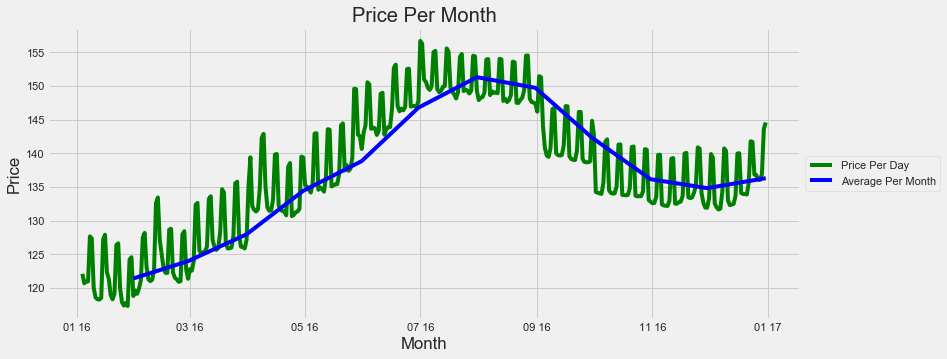

In [7]:
cal_price_per_day = availability_df[availability_df['year'] == 2016].groupby('date', as_index=True).agg(
    reserve_price = ('reserve_price',np.mean)
)

price_per_month = cal_price_per_day.copy()
price_per_month = price_per_month.resample('M').mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax = plt.subplot(111) 
locator = mdates.AutoDateLocator()

ax.plot(cal_price_per_day.index.values,
        cal_price_per_day.reserve_price,
        label="Price Per Day",
        color='green')

ax.plot(price_per_month.index.values,
        price_per_month.reserve_price,
        label="Average Per Month",
        color='blue')

# Set title and labels for axes
ax.set(xlabel="Month",
       ylabel="Price",
       title="Price Per Month")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.xaxis.set_major_locator(locator)
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m %y'))

plt.show()

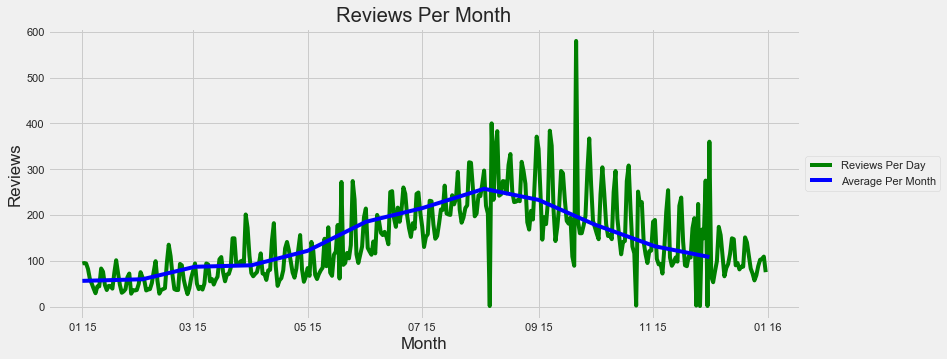

In [8]:
# reviews per month
cal_reviews_per_day = reviews_df[reviews_df['year'] == 2015].groupby('date', as_index=True).agg(
    review_count = ('id','count')
)

cal_reviews_per_month = cal_reviews_per_day.copy()
cal_reviews_per_month = cal_reviews_per_month.resample('BMS').mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax = plt.subplot(111) 

locator = mdates.AutoDateLocator()

ax.plot(cal_reviews_per_day.index.values,
        cal_reviews_per_day.review_count,
        label="Reviews Per Day",
        color='green')

ax.plot(cal_reviews_per_month.index.values,
        cal_reviews_per_month.review_count,
        label="Average Per Month",
        color='blue')

# Set title and labels for axes
ax.set(xlabel="Month",
       ylabel="Reviews",
       title="Reviews Per Month")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.xaxis.set_major_locator(locator)
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m %y'))

plt.show()

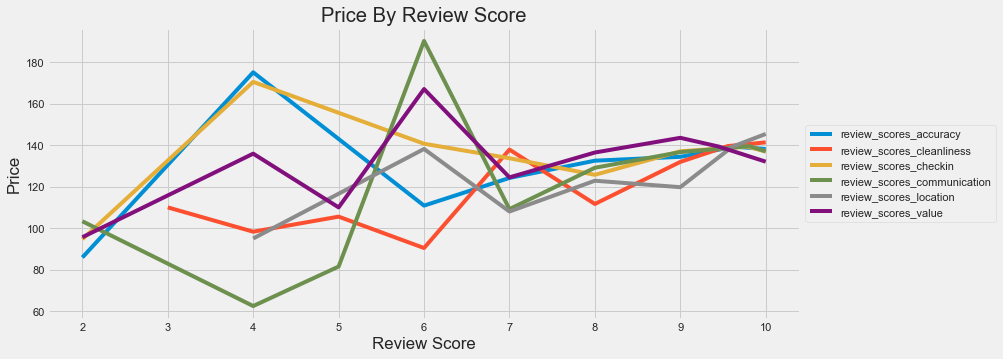

In [9]:
#review stuff by prices
review_cols = availability_df.filter(like='review_scores').columns

fig, ax = plt.subplots(figsize=(12, 5))
ax = plt.subplot(111) 

# listing id 6370313 has a checkin score of 5 and skews the graph
for col in review_cols:
    if (col != 'review_scores_rating'):
        price_by_col = availability_df[availability_df['listing_id'] != 6370313].groupby(col)['reserve_price'].mean()
        ax.plot(price_by_col, label=col)
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set title and labels for axes
ax.set(xlabel="Review Score",
       ylabel="Price",
       title="Price By Review Score")

plt.show()

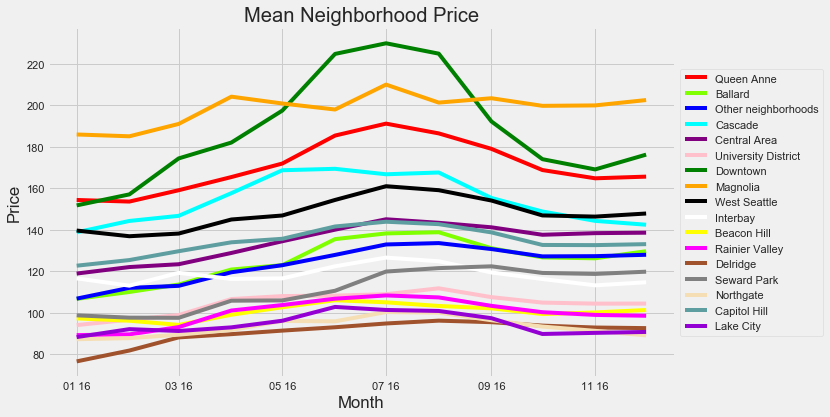

In [10]:
neighbourhood_colors = {
    "Queen Anne":"red",
    "Ballard":"chartreuse",
    "Other neighborhoods":"blue",
    "Cascade":"cyan",
    "Central Area":"purple",
    "University District":"pink",
    "Downtown":"green",
    "Magnolia":"orange",
    "West Seattle":"black",
    "Interbay":"white",
    "Beacon Hill":"yellow",
    "Rainier Valley":"magenta",
    "Delridge":"sienna",
    "Seward Park":"gray",
    "Northgate":"wheat",
    "Capitol Hill":"cadetblue",
    "Lake City":"darkviolet"
}


availability_df['month_begin_date'] = availability_df['date'] - pd.offsets.MonthBegin(1)
cal_price_neighbourhood = availability_df.groupby(['month_begin_date','neighbourhood_group_cleansed'])['reserve_price'].mean()

fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)

neighbourhood_list = listings_df['neighbourhood_group_cleansed'].unique()
for nh in neighbourhood_list:
    nh_price_per_month = availability_df[(availability_df['neighbourhood_group_cleansed'] == nh) & (availability_df['year'] == 2016)].groupby('month_begin_date', as_index=True).agg(
        reserve_price = ('reserve_price',np.mean)
    )
    ax.plot(nh_price_per_month.index.values,
            nh_price_per_month['reserve_price'],
            label = nh,
            color = neighbourhood_colors[nh],
            linestyle='solid')
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * .5, box.height * .5])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel('Price')
plt.xlabel('Month')
plt.title('Mean Neighborhood Price')

plt.savefig('Average Neighborhood Price By Month')

ax.xaxis.set_major_locator(locator)
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m %y'))

plt.show()

In [11]:
# Determine Feature Weights
r_state = 42

# Select Only Certain Columns For the Model
model_cols = ['cleaning_fee','neighbourhood_group_cleansed','property_type',
              'room_type', 'accommodates','bathrooms','bedrooms','beds','bed_type',
              'reserve_price','month','dayofweek','guests_included','minimum_nights',
              'review_scores_rating', 'review_scores_accuracy',
              'review_scores_cleanliness', 'review_scores_checkin',
              'review_scores_communication', 'review_scores_location',
              'review_scores_value']
model_df = availability_df[model_cols].copy()

# One Hot Encode The Enum Columns
one_hot_columns = list(model_df.select_dtypes(include=['object']).columns)
model_df = create_dummy_df(model_df,one_hot_columns, False)

# Run Random Forest Regressor to determine most important features.
x = model_df.drop(columns='reserve_price')
y = model_df[['reserve_price']]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.30, random_state=r_state)
rf_model = RandomForestRegressor(n_estimators=100, random_state=r_state)
rf_model.fit(x, y.squeeze())
y_predict = rf_model.predict(x_test)
rs = r2_score(y_test,y_predict)
rs

0.9900810618160616

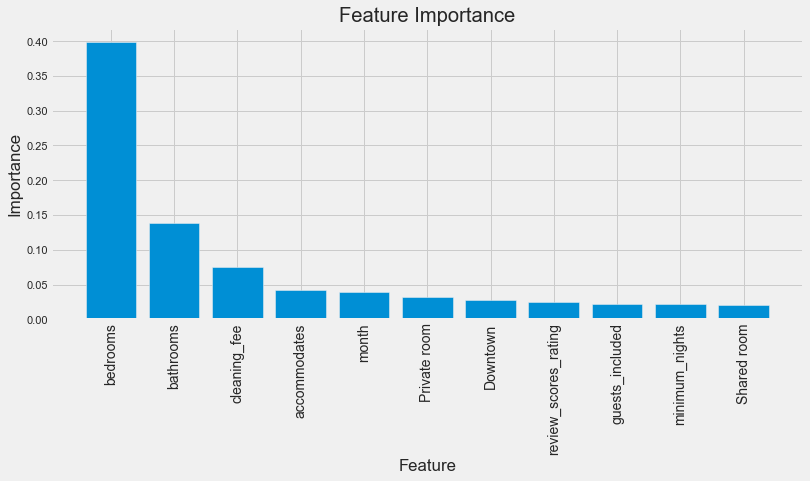

In [12]:
# Graph most important features by descending importance
features = sorted(zip(x_train.columns, rf_model.feature_importances_), key=itemgetter(1), reverse=True)

df_feature_importance = pd.DataFrame(features, columns=['feature','importance'])
df_feature_importance = df_feature_importance[:11]

df_feature_importance["feature"] = df_feature_importance["feature"].apply(clean_up_feature_name)

plt.figure(figsize=(12,5))
plt.xticks(rotation=90,fontsize=14)
plt.bar(df_feature_importance['feature'],
         df_feature_importance['importance'])
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance')
plt.show()

Text(0.5, 1.0, 'Mean Neighborhood Price')

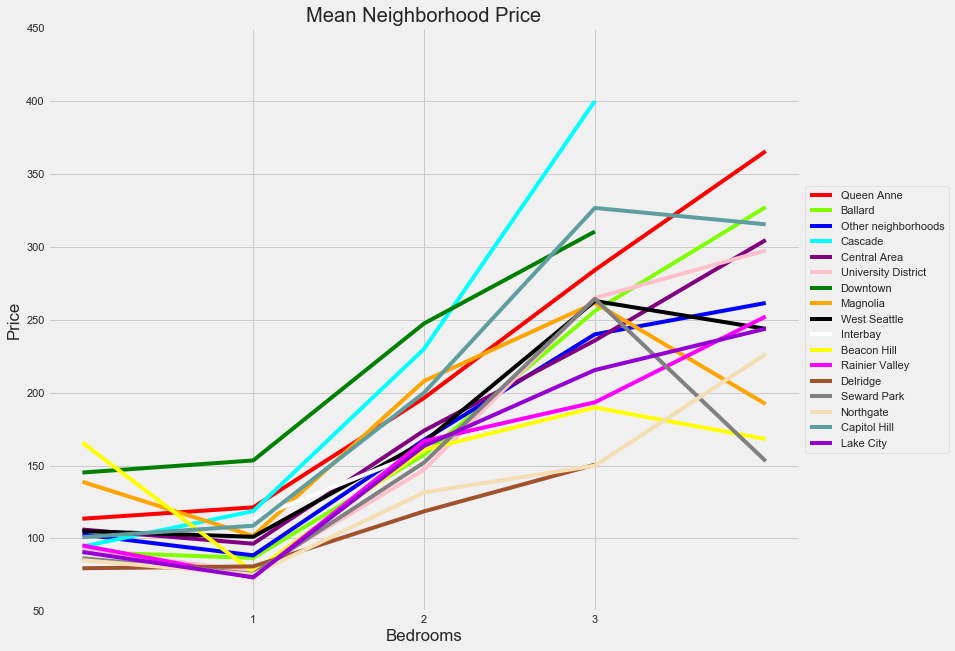

In [13]:
# Lets make a lookup table then by bedrooms and neighborhood
neighbourhood_list = listings_df['neighbourhood_group_cleansed'].unique()

#get prices by month and neighbourhood
price_by_br_neighbourhood = availability_df[(availability_df.reserve_price < 450) & (availability_df.bedrooms <= 4)].groupby(['bedrooms','neighbourhood_group_cleansed'])['reserve_price'].mean().reset_index()
price_by_br_neighbourhood

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111) 

for nh in neighbourhood_list:
    ax.plot(price_by_br_neighbourhood[price_by_br_neighbourhood['neighbourhood_group_cleansed'] == nh]['bedrooms'],
            price_by_br_neighbourhood[price_by_br_neighbourhood['neighbourhood_group_cleansed'] == nh]['reserve_price'],
             label = nh,
             color = neighbourhood_colors[nh],
             linestyle='solid')
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(np.arange(1, 4, step=1))
plt.yticks(np.arange(50, 500, step=50))
plt.ylabel('Price')
plt.xlabel('Bedrooms')
plt.title('Mean Neighborhood Price')

Additional Data Exploration Not Used in Post

Text(0.5, 1.0, 'Price Per HRR')

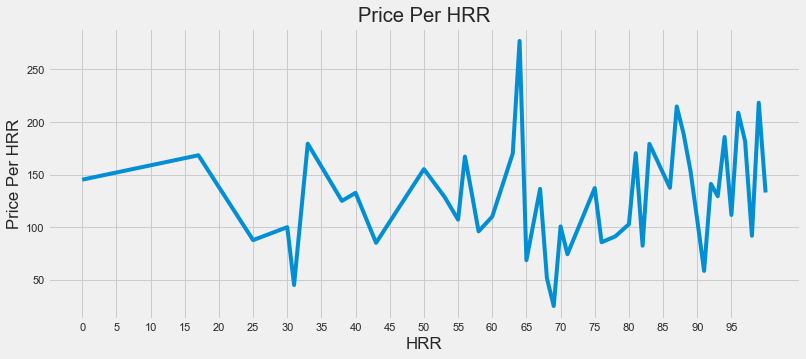

In [14]:
# Examing Response Rate By Price

price_by_response_rate = availability_df.groupby('host_response_rate')['reserve_price'].mean()
plt.figure(figsize=(12,5))
plt.plot(price_by_response_rate)
plt.xticks(np.arange(0, 100, step=5))
plt.ylabel('Price Per HRR')
plt.xlabel('HRR')
plt.title('Price Per HRR')

Text(0.5, 1.0, 'Price Per HRT')

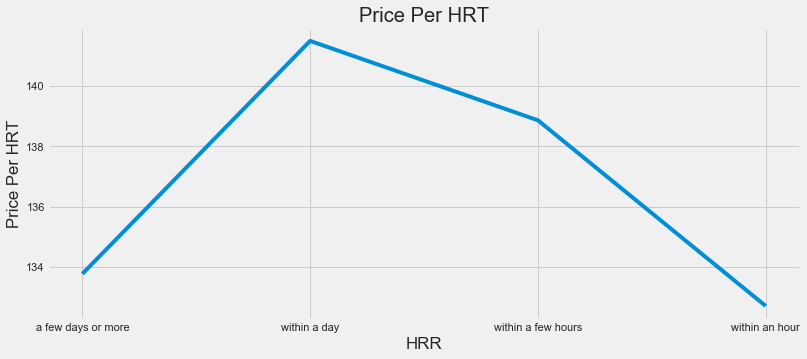

In [15]:
# Examing Response Time By Price

price_by_response_time = availability_df.groupby('host_response_time')['reserve_price'].mean()
plt.figure(figsize=(12,5))
plt.plot(price_by_response_time)
#plt.yticks(np.arange(100, 200, step=10))
plt.ylabel('Price Per HRT')
plt.xlabel('HRR')
plt.title('Price Per HRT')

Text(0.5, 1.0, 'Price Per Bedroom')

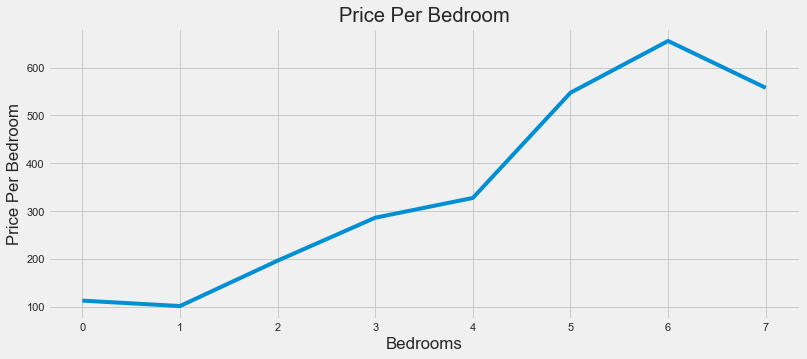

In [16]:
# Bedroom pricing - obvious increase although 0 is slightly higher than 1 so its possible we should use mode or mean for
# null bedrooms rather than 0

price_by_bedrooms = availability_df.groupby('bedrooms')['reserve_price'].mean()
plt.figure(figsize=(12,5))
plt.plot(price_by_bedrooms)
#plt.yticks(np.arange(100, 200, step=10))
plt.ylabel('Price Per Bedroom')
plt.xlabel('Bedrooms')
plt.title('Price Per Bedroom')

Text(0.5, 1.0, 'Price Per Cancellation Policy')

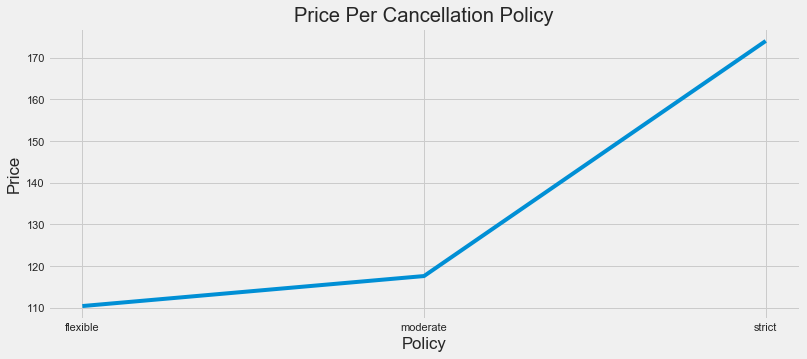

In [17]:
#Cancellation Policy
price_by_policy = availability_df.groupby('cancellation_policy')['reserve_price'].mean()
plt.figure(figsize=(12,5))
plt.plot(price_by_policy)
#plt.yticks(np.arange(100, 200, step=10))
plt.ylabel('Price')
plt.xlabel('Policy')
plt.title('Price Per Cancellation Policy')

Text(0.5, 1.0, 'Price Per Property Type')

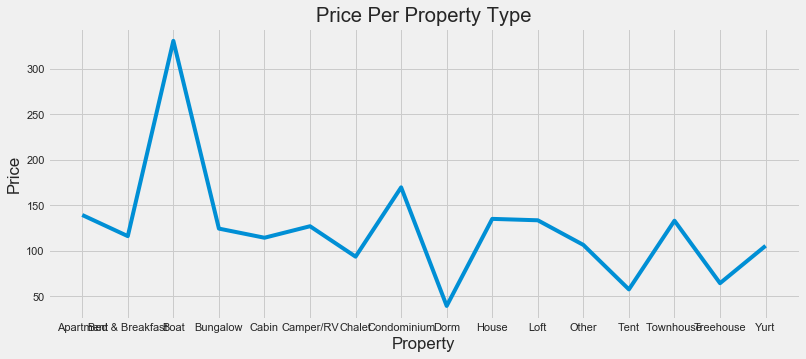

In [18]:
#property_type
price_by_policy = availability_df.groupby('property_type')['reserve_price'].mean()
plt.figure(figsize=(12,5))
plt.plot(price_by_policy)
#plt.yticks(np.arange(100, 200, step=10))
plt.ylabel('Price')
plt.xlabel('Property')
plt.title('Price Per Property Type')

Text(0.5, 1.0, 'Price Per Room Type')

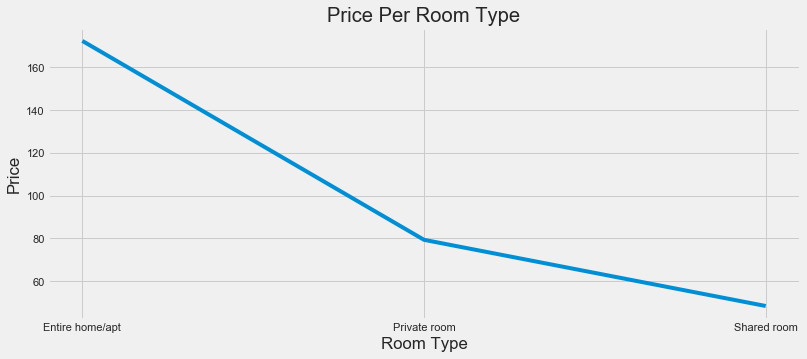

In [19]:
#room_type
price_by_policy = availability_df.groupby('room_type')['reserve_price'].mean()
plt.figure(figsize=(12,5))
plt.plot(price_by_policy)
#plt.yticks(np.arange(100, 200, step=10))
plt.ylabel('Price')
plt.xlabel('Room Type')
plt.title('Price Per Room Type')

Text(0.5, 1.0, 'Price Per Min Nights')

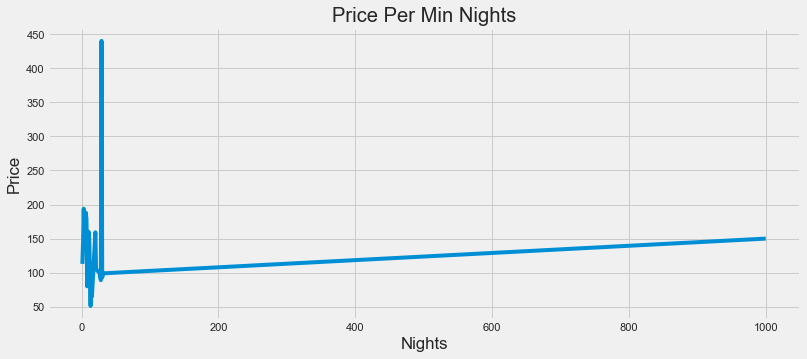

In [20]:
#minimum_nights
price_by_policy = availability_df.groupby('minimum_nights')['reserve_price'].mean()
plt.figure(figsize=(12,5))
plt.plot(price_by_policy)
#plt.yticks(np.arange(100, 200, step=10))
plt.ylabel('Price')
plt.xlabel('Nights')
plt.title('Price Per Min Nights')